# This script processes the tree related statistics generated by owm_stats.cpp  

1. Generate the file [CloudName].xyz.csv by compiling and running:
    ```
    make bin/stats
    cd scripts
    python3 run_stats.py 
    ```

run_stats.py uses the MinRadius values that result in minimum time without using memoization for OWM= [0.9,0.6,0.2,0.2] and the same for MaxNumber=[512,512,1024,512]

2. Collect the files generated in the cloud directory, with names [CloudName].xyz.csv

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

def readstats(filename):
    f=open(filename)
    lines=f.readlines()
    f.close()

    stats={}
    for line,linenum in zip(lines,range(17)):
        print(line,end='')
    max_histo=int(lines[10].split()[1])
    print('max_histo:',max_histo)

    x=[]
    y=[]
    for line in lines[21:]:
        line=line.split()
        x.append(int(line[0]))
        y.append(int(line[1]))
        if int(line[0])==max_histo:
            break
    return (x,y,max_histo)

clouds=['Alcoy','Arzua','BrionF','BrionU']
dir='statsWithoutMemo/MinRadHisto/'
all_histos=[]
all_nph=[]
for cloud in clouds:
    print('Cloud:',cloud)
    x,y,maxh=readstats(dir+cloud+'H_salida.xyz.csv')
    all_histos.append((x,y))
    print('maxh:',maxh)
    all_nph.append(np.zeros(maxh+1))
    for i in range(len(x)):
        all_nph[-1][x[i]]=y[i]

all_histos[0][1][0]


Cloud: Alcoy
HISTOGRAM: ../bin/data/AlcoyH_salida.xyz.csv
N_puntos: 20380212
N_nodos: 597725
N_nodos_hoja: 448294
MinRadius: 0.9 m
Area_minima: 3.24 m^2

OBSERVADO: 
N_medio_pts/nodo: 45
__min: 0
__max: 1565
Densidad_media: 14.0314
__min: 0
__max: 483.025

ESTIMADO: 
N_medio_pts/nodo: 24.5387
max_histo: 1565
maxh: 1565
Cloud: Arzua
HISTOGRAM: ../bin/data/ArzuaH_salida.xyz.csv
N_puntos: 40706503
N_nodos: 349525
N_nodos_hoja: 262144
MinRadius: 0.6 m
Area_minima: 1.44 m^2

OBSERVADO: 
N_medio_pts/nodo: 155
__min: 0
__max: 6606
Densidad_media: 107.835
__min: 0
__max: 4587.5

ESTIMADO: 
N_medio_pts/nodo: 58.6185
max_histo: 6606
maxh: 6606
Cloud: BrionF
HISTOGRAM: ../bin/data/BrionFH_salida.xyz.csv
N_puntos: 42384876
N_nodos: 803725
N_nodos_hoja: 602794
MinRadius: 0.2 m
Area_minima: 0.16 m^2

OBSERVADO: 
N_medio_pts/nodo: 70
__min: 0
__max: 686
Densidad_media: 439.463
__min: 0
__max: 4287.5

ESTIMADO: 
N_medio_pts/nodo: 19.152
max_histo: 686
maxh: 686
Cloud: BrionU
HISTOGRAM: ../bin/data/Bri

5358

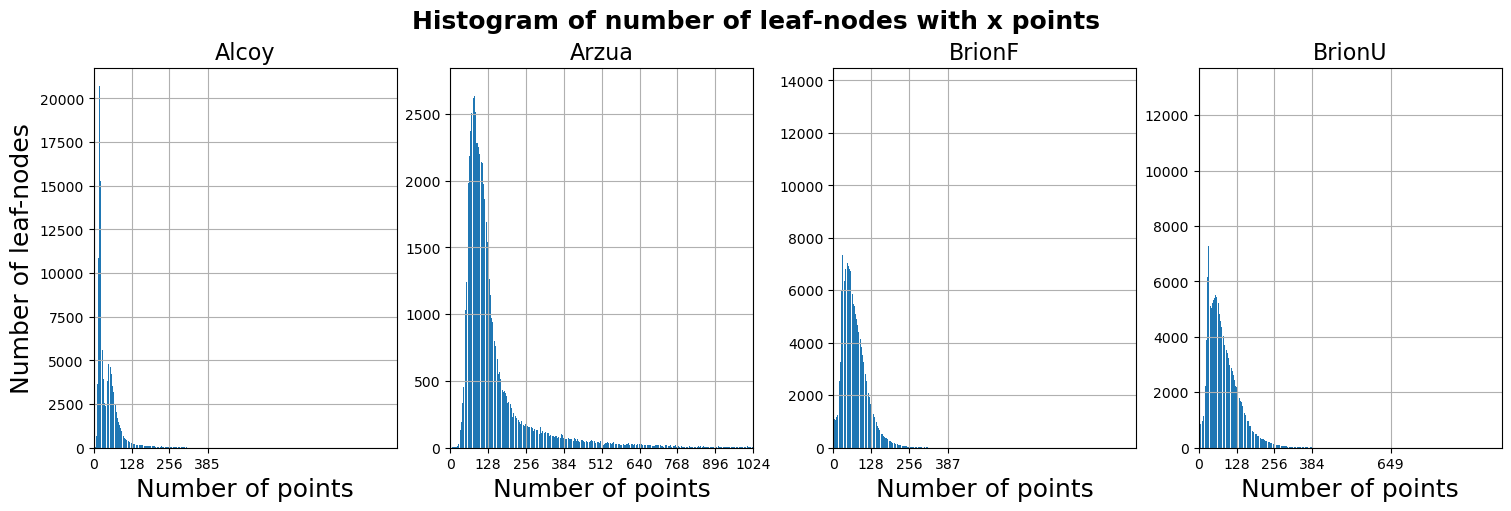

In [8]:
def plot_histo(all_histo):
    #Configuration variables
    titlefs = 20
    ylabelfs = 18
    xlabelfs = 18
    xticksfs = 16
    yticksfs = 16
    legendfs = 14
    linew = 2
    markers = 8
    marks=['o-','x-','s-','v-','+-']

    clouds=['Alcoy','Arzua','BrionF','BrionU']
    limits=[1500,3000,600,600]
    
    #fig = plt.figure()
    labels=['Histogram']
    #define grid of plots
    fig, axs = plt.subplots(nrows=1, ncols=4,figsize=(15, 5), constrained_layout=True)
    for i,name,l in zip(range(len(clouds)),clouds,limits):
        axs[i].bar(all_histos[i][0], all_histos[i][1])

        axs[i].set_title(name,fontsize=16)
        axs[i].set_xlabel('Number of points', fontsize=xlabelfs)
        axs[i].set_xticks(all_histos[i][0][::128],fontsize=xticksfs)
        axs[i].set_xlim(0,1024)
        #axs[i].set_ylim(0,l)

        # axs[i].yticks(fontsize=yticksfs)
        axs[i].grid()
    fig.suptitle('Histogram of number of leaf-nodes with x points',  fontweight='bold', fontsize=18)
    
    axs[0].set_ylabel('Number of leaf-nodes', fontsize=ylabelfs)
    #axs[0].legend(labels,loc='best', fontsize= 14)
    pp = PdfPages("Histogram_num_points_minrad.pdf")
    pp.savefig(fig)
    pp.close()

plot_histo(all_histos)

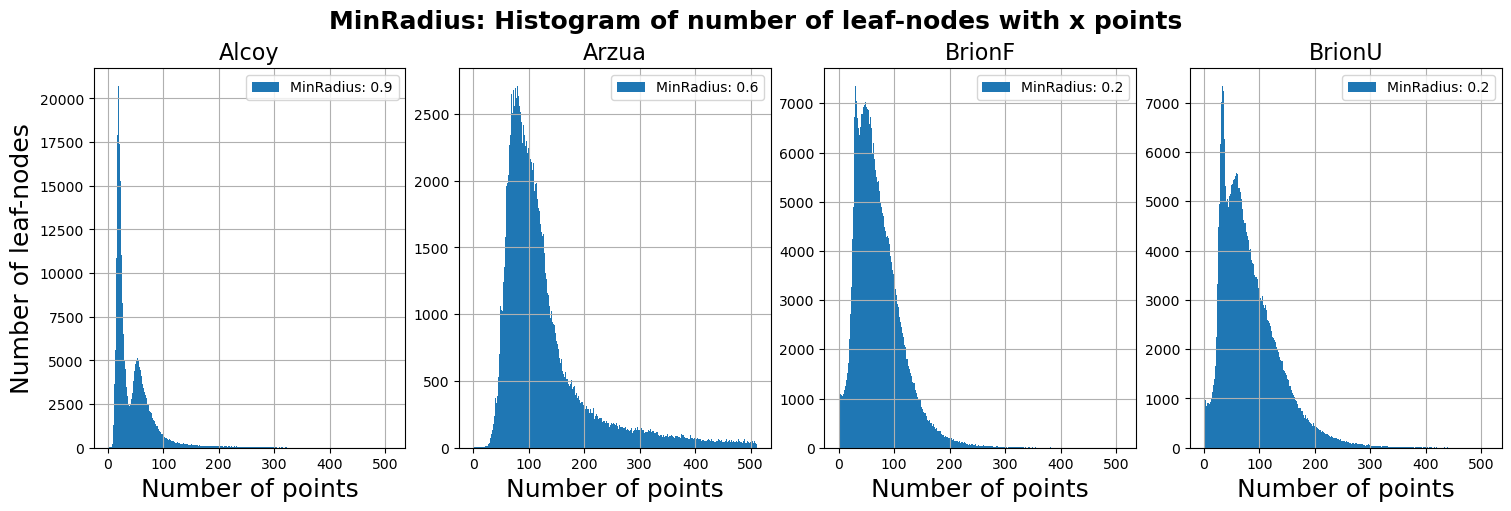

In [9]:
def plot_histo2(all_histo):
    #Configuration variables
    titlefs = 20
    ylabelfs = 18
    xlabelfs = 18
    xticksfs = 16
    yticksfs = 16
    legendfs = 14
    linew = 2
    markers = 8
    marks=['o-','x-','s-','v-','+-']

    clouds=['Alcoy','Arzua','BrionF','BrionU']
    limits=[1500,3000,600,600]
    minRadius=[0.9,0.6,0.2,0.2]
    
    #define grid of plots
    fig, axs = plt.subplots(nrows=1, ncols=4,figsize=(15, 5), constrained_layout=True)
    for i,name,l in zip(range(len(clouds)),clouds,limits):
        axs[i].stairs(all_histo[i][1:512],np.arange(0,512),fill=True,label='MinRadius: '+str(minRadius[i]))
        #axs[i].set_label('MinRadius: '+str(minRadius[i]))
        axs[i].set_title(name,fontsize=16)
        axs[i].set_xlabel('Number of points', fontsize=xlabelfs)
        #axs[i].set_xticks(all_histos[i][0][::128],fontsize=xticksfs)
        #axs[i].set_xlim(0,1024)
        #axs[i].set_ylim(0,l)

        # axs[i].yticks(fontsize=yticksfs)
        axs[i].grid()
        axs[i].legend(loc='best', fontsize= 10)
    fig.suptitle('MinRadius: Histogram of number of leaf-nodes with x points',  fontweight='bold', fontsize=18)
    
    axs[0].set_ylabel('Number of leaf-nodes', fontsize=ylabelfs)
    pp = PdfPages("Histogram_num_points_minrad2.pdf")
    pp.savefig(fig)
    pp.close()

# plt.grid(True)
# plt.show()

plot_histo2(all_nph)

# Compute the histograms for maxNumber results

In [10]:
dir='statsWithoutMemo/MaxNumHisto/'
all_histos_mn=[]
all_nph_mn=[]
for cloud in clouds:
    print('Cloud:',cloud)
    x,y,maxh=readstats(dir+cloud+'H_salida.xyz.csv')
    all_histos_mn.append((x,y))
    print('maxh:',maxh)
    all_nph_mn.append(np.zeros(maxh+1))
    for i in range(len(x)):
        all_nph_mn[-1][x[i]]=y[i]

all_histos_mn[0][1][0]

Cloud: Alcoy
HISTOGRAM: ../bin/data/AlcoyH_salida.xyz.csv
N_puntos: 20380212
N_nodos: 112049
N_nodos_hoja: 84031
MinRadius: 0.1 m
Area_minima: 0.04 m^2

OBSERVADO: 
N_medio_pts/nodo: 242
__min: 0
__max: 512
Densidad_media: 6063.3
__min: 0
__max: 12800

ESTIMADO: 
N_medio_pts/nodo: 0.302947
max_histo: 512
maxh: 512
Cloud: Arzua
HISTOGRAM: ../bin/data/ArzuaH_salida.xyz.csv
N_puntos: 40706503
N_nodos: 224485
N_nodos_hoja: 168357
MinRadius: 0.1 m
Area_minima: 0.04 m^2

OBSERVADO: 
N_medio_pts/nodo: 241
__min: 0
__max: 512
Densidad_media: 6044.66
__min: 0
__max: 12800

ESTIMADO: 
N_medio_pts/nodo: 1.62829
max_histo: 512
maxh: 512
Cloud: BrionF
HISTOGRAM: ../bin/data/BrionFH_salida.xyz.csv
N_puntos: 42384876
N_nodos: 129797
N_nodos_hoja: 97342
MinRadius: 0.1 m
Area_minima: 0.04 m^2

OBSERVADO: 
N_medio_pts/nodo: 435
__min: 0
__max: 1024
Densidad_media: 10885.6
__min: 0
__max: 25600

ESTIMADO: 
N_medio_pts/nodo: 4.78799
max_histo: 1024
maxh: 1024
Cloud: BrionU
HISTOGRAM: ../bin/data/BrionUH_s

2998

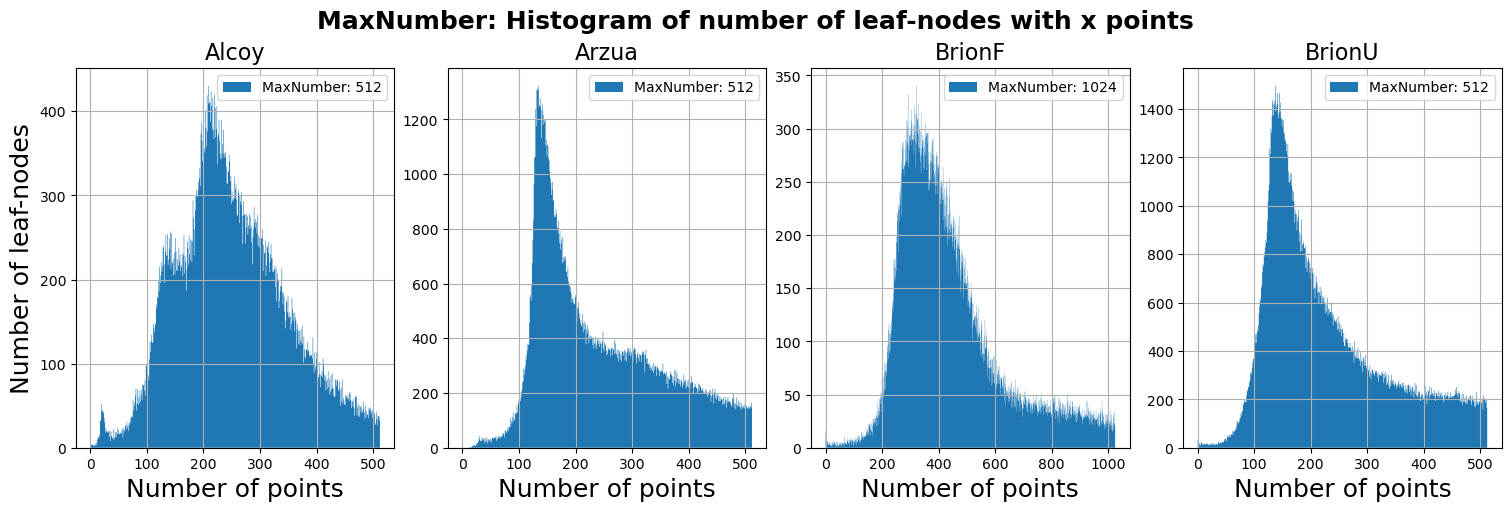

In [11]:
def plot_histo_mn(all_histo):
    #Configuration variables
    titlefs = 20
    ylabelfs = 18
    xlabelfs = 18
    xticksfs = 16
    yticksfs = 16
    legendfs = 14
    linew = 2
    markers = 8
    marks=['o-','x-','s-','v-','+-']

    clouds=['Alcoy','Arzua','BrionF','BrionU']
    limits=[1500,3000,600,600]
    maxNumber=[512,512,1024,512]

    #define grid of plots
    fig, axs = plt.subplots(nrows=1, ncols=4,figsize=(15, 5), constrained_layout=True)
    for i,name,l in zip(range(len(clouds)),clouds,limits):
        axs[i].stairs(all_histo[i][1:],fill=True,label='MaxNumber: '+str(maxNumber[i]))

        axs[i].set_title(name,fontsize=16)
        axs[i].set_xlabel('Number of points', fontsize=xlabelfs)
        #axs[i].set_xticks(all_histos[i][0][::128],fontsize=xticksfs)
        #axs[i].set_xlim(0,1024)
        #axs[i].set_ylim(0,l)

        # axs[i].yticks(fontsize=yticksfs)
        axs[i].grid()
        axs[i].legend(loc='best', fontsize= 10,markerscale=0.2)
    fig.suptitle('MaxNumber: Histogram of number of leaf-nodes with x points',  fontweight='bold', fontsize=18)
    
    axs[0].set_ylabel('Number of leaf-nodes', fontsize=ylabelfs)
    #axs[0].legend(labels,loc='best', fontsize= 14)
    pp = PdfPages("Histogram_num_points_maxnum2.pdf")
    pp.savefig(fig)
    pp.close()

# plt.grid(True)
# plt.show()

plot_histo_mn(all_nph_mn)

# Build LaTeX table

In [15]:
def readlevels(filename):
    f=open(filename)
    lines=f.readlines()
    f.close()

    linenumber=0
    levels={}
    for line in lines:
        if 'HISTOGRAM_DE_NIVELES:' in line:
            break
        else:
            linenumber=linenumber+1
    #print(lines[linenumber+5:])
    for line in lines[linenumber+5:-2]:
        line=line.split()
        levels[int(line[0])]=int(line[1])
    print(levels)
    return levels

clouds=['Alcoy','Arzua','BrionF','BrionU']
dir='statsWithoutMemo/MinRadHisto/'
all_hminrad=[]
total_minrad=[]
for cloud in clouds:
    print('Cloud:',cloud)
    x=readlevels(dir+cloud+'H_salida.xyz.csv')
    all_hminrad.append(x)
    total_minrad.append(sum(x.values()))

dir='statsWithoutMemo/MaxNumHisto/'
all_hmaxnum=[]
total_maxnum=[]
for cloud in clouds:
    print('Cloud:',cloud)
    x=readlevels(dir+cloud+'H_salida.xyz.csv')
    all_hmaxnum.append(x)
    total_maxnum.append(sum(x.values()))



Cloud: Alcoy
{6: 2266, 7: 186, 8: 564, 9: 758, 10: 444520}
Cloud: Arzua
{9: 262144}
Cloud: BrionF
{6: 1593, 7: 318, 8: 812, 9: 2451, 10: 597620}
Cloud: BrionU
{6: 1664, 7: 295, 8: 823, 9: 2380, 10: 581024}
Cloud: Alcoy
{6: 2285, 7: 180, 8: 14580, 9: 50638, 10: 16239, 11: 95, 12: 20}
Cloud: Arzua
{7: 4, 8: 41742, 9: 85777, 10: 36211, 11: 4480, 12: 142, 13: 8}
Cloud: BrionF
{6: 1668, 7: 498, 8: 17560, 9: 77038, 10: 584}
Cloud: BrionU
{6: 1711, 7: 404, 8: 4247, 9: 104066, 10: 100452, 11: 144}


In [16]:
print("\\begin{tabular}{|c|cccc|cccc|}\hline")
print(" & \multicolumn{4}{c|}{MinRadius} & \multicolumn{4}{c|}{MaxNumber} \\\\ \hline")  
print(" Level & Alcoy & Arzua & BrionF & BrionU & Alcoy & Arzua & BrionF & BrionU \\\\ \hline")
for lev in range(6,14):
    print(lev,end='')
    for i in range(4):
        if all_hminrad[i].get(lev) is None:
            print(" & 0",end='')
        else:
            print(" & {}".format(all_hminrad[i][lev]),end='')
    for i in range(4):
        if all_hmaxnum[i].get(lev) is None:
            print(" & 0",end='')
        else:
            print(" & {}".format(all_hmaxnum[i][lev]),end='')
    print("\\\\ \hline")
print("Total:",end='')
for i in range(4):
    print(" & {}".format(total_minrad[i]),end='')
for i in range(4):
    print(" & {}".format(total_maxnum[i]),end='')
print("\\\\ \hline")
print("\\end{tabular}")

\begin{tabular}{|c|cccc|cccc|}\hline
 & \multicolumn{4}{c|}{MinRadius} & \multicolumn{4}{c|}{MaxNumber} \\ \hline
 Level & Alcoy & Arzua & BrionF & BrionU & Alcoy & Arzua & BrionF & BrionU \\ \hline
6 & 2266 & 0 & 1593 & 1664 & 2285 & 0 & 1668 & 1711\\ \hline
7 & 186 & 0 & 318 & 295 & 180 & 4 & 498 & 404\\ \hline
8 & 564 & 0 & 812 & 823 & 14580 & 41742 & 17560 & 4247\\ \hline
9 & 758 & 262144 & 2451 & 2380 & 50638 & 85777 & 77038 & 104066\\ \hline
10 & 444520 & 0 & 597620 & 581024 & 16239 & 36211 & 584 & 100452\\ \hline
11 & 0 & 0 & 0 & 0 & 95 & 4480 & 0 & 144\\ \hline
12 & 0 & 0 & 0 & 0 & 20 & 142 & 0 & 0\\ \hline
13 & 0 & 0 & 0 & 0 & 0 & 8 & 0 & 0\\ \hline
Total: & 448294 & 262144 & 602794 & 586186 & 84037 & 168364 & 97348 & 211024\\ \hline
\end{tabular}
